# Flow past a cylinder

In [21]:
using ViscousFlow

In [22]:
using Plots
pyplot()
default(grid = false)

### Solve flow past a stationary body

Set the flow parameters

In [23]:
Re = 200; # Reynolds number
U = 1.0; # Free stream velocity
U∞ = (U,0.0);

Set up points on the body.

In [24]:
n = 157;
body = Circle(0.5,n)

Circular body with 157 points and radius 0.5
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


Transform the body to lie at a specific position. Here, we just put it at the origin.

In [25]:
cent = (0.0,0.0)
α = 0.0
T = RigidTransform(cent,α)
T(body) # transform the body to the current configuration

Circular body with 157 points and radius 0.5
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


Set up the domain and plot the body inside it.

In [26]:
xlim = (-1.0,4.0)
ylim = (-2.0,2.0);

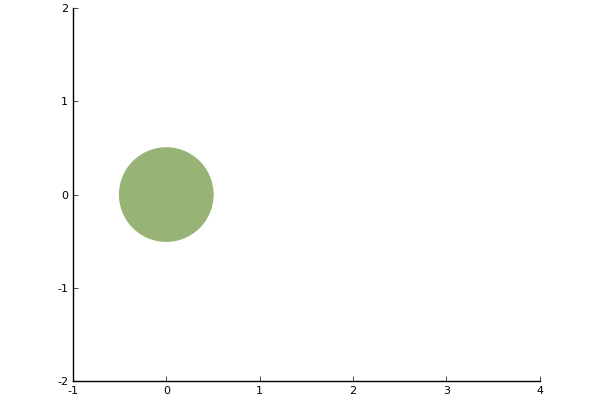

In [27]:
plot(body,xlim=xlim,ylim=ylim)

Now set up the coordinate data for operator construction

In [28]:
X = VectorData(body.x,body.y);
#X̃ = VectorData(body.x̃,body.ỹ);

Set the grid cell size and time step size.

In [29]:
Δx = 0.02
cfl = 0.5
Δt = min(cfl*Δx,0.5*Δx^2*Re)

0.01

### Now set up the system

Set up the state vector and constraint force vector for a static body

In [30]:
sys = NavierStokes(Re,Δx,xlim,ylim,Δt,U∞ = U∞, X̃ = X, isstore = true)

Navier-Stokes system on a grid of size 252 x 208

In [31]:
w₀ = Nodes(Dual,size(sys));
f = VectorData(X);

In [32]:
wf = PointForce(w₀,(1.5,0.0),10.0,4.0,1.0,sys)

Transient point force applied on the Nodes{Dual,252,208,Float64,Array{Float64,2}} field.
   strength = 10.0
   location = (1.5, 0.0)
   central time = 4.0
   half-interval = 1.0


In [33]:
xg, yg = coordinates(w₀,dx=Δx,I0=origin(sys))

(-1.01:0.02:4.01, -2.07:0.02:2.07)

Set up the integrator here

In [34]:
plan_intfact(t,u) = CartesianGrids.plan_intfact(t,u,sys)
plan_constraints(u,t) = ConstrainedSystems.plan_constraints(u,t,sys)
r₁(u,t) = ConstrainedSystems.r₁(u,t,sys) + wf(t)
r₂(u,t) = ConstrainedSystems.r₂(u,t,sys)

@time solver = IFHERK(w₀,f,sys.Δt,plan_intfact,plan_constraints,(r₁,r₂),rk=ConstrainedSystems.RK31)

  5.340913 seconds (928.08 k allocations: 3.130 GiB, 9.02% gc time)


Order-3 IF-HERK integrator with
   State of type Nodes{Dual,252,208,Float64,Array{Float64,2}}
   Force of type VectorData{157,Float64,Array{Float64,1}}
   Time step size 0.01


Initialize the state vector and the history vectors

In [35]:
t = 0.0
u = deepcopy(w₀)

fx = Float64[];
fy = Float64[];
thist = Float64[];

uhist = [];
tsample = 0.2; # rate at which to store field data

### Advance the system!

Set the time range to integrate over.

In [36]:
tf = 10.0;
T = Δt:Δt:tf;

In [37]:
@time for ti in T
    global t, u, f = solver(t,u)
    
    push!(thist,t)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    (isapprox(mod(t,tsample),0,atol=1e-8) || isapprox(mod(t,tsample),tsample,atol=1e-8)) ? push!(uhist,deepcopy(u)) : nothing
end
println("solution completed through time t = ",t)

 65.749457 seconds (2.88 M allocations: 37.222 GiB, 8.70% gc time)
solution completed through time t = 9.999999999999831


#### Plotting

Basic plot

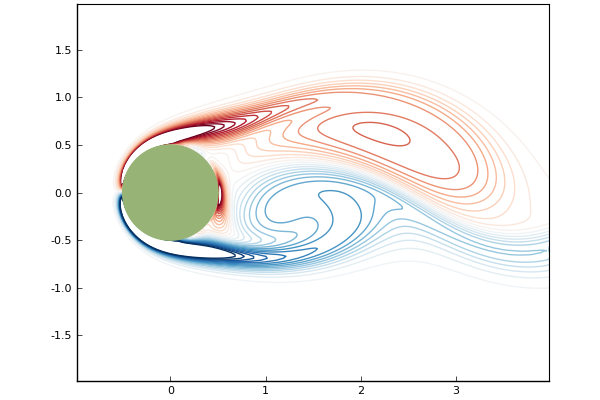

In [38]:
plot(xg,yg,vorticity(uhist[end],sys),levels=range(-5,stop=5,length=30), color = :RdBu,clims=(-5,5),xlim=(-1+Δx,4-Δx),ylim=(-2+Δx,2-Δx),width=1,legend=:false)
plot!(body)

In [39]:
ψ = zero(uhist[1])
ψ .= streamfunction(uhist[end-10],sys) .+ sys.U∞[1]*yg';

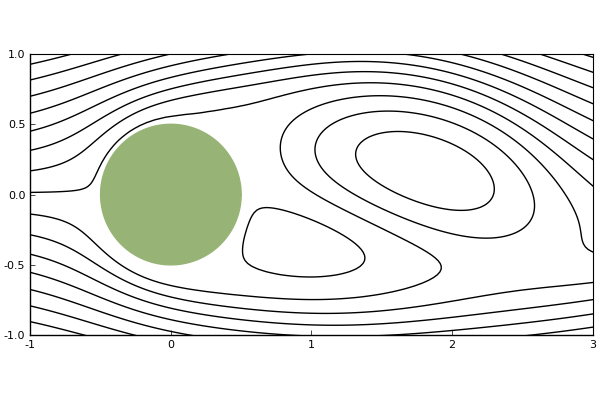

In [40]:
plot(xg,yg,ψ,levels=range(-2,1,length=31), color = :black,clim=(-0.25,0.25),xlim=(-1,3),ylim=(-1,1))
plot!(body)

Make a movie

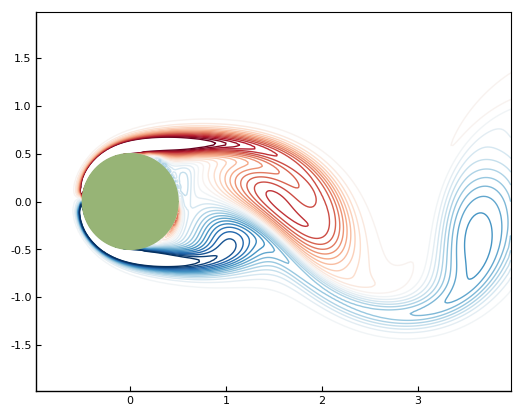

┌ Info: Saved animation to 
│   fn = /Users/jeff/ViscousFlow/examples/cylinderRe200-2.gif
└ @ Plots /Users/jeff/.julia/packages/Plots/QYETN/src/animation.jl:90


Plots.AnimatedGif("/Users/jeff/ViscousFlow/examples/cylinderRe200-2.gif")

In [142]:
anim = @animate for i = 1:length(uhist)
    plot(xg,yg,uhist[i],levels=range(-0.1,stop=0.1,length=30),color = :RdBu,clims=(-0.1,0.1),xlim=(-1+Δx,4-Δx),ylim=(-2+Δx,2-Δx))
    plot!(body)
end
gif(anim,"cylinderRe200-2.gif")

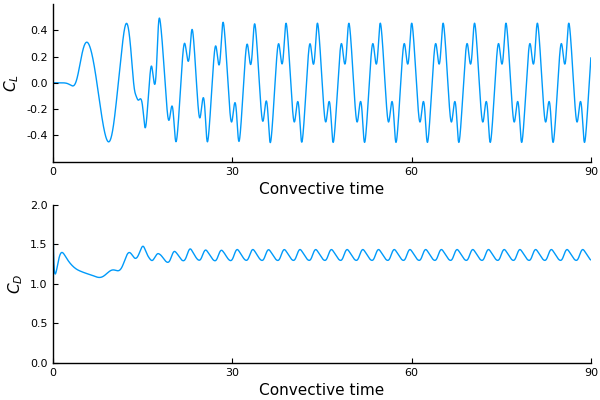

In [120]:
plt = plot(layout = (2,1), size = (600, 400))
plot!(plt[1],thist,2*fy,xlim=(0,90),ylim=(-0.6,0.6),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot!(plt[2],thist,2*fx,xlim=(0,90),ylim=(0,2),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
plt

In [67]:
using Statistics

In [70]:
thist[end]

39.99100000000114

In [121]:
Statistics.mean(2*fx[2000:end])

1.361513249387222

In [72]:
using FFTW

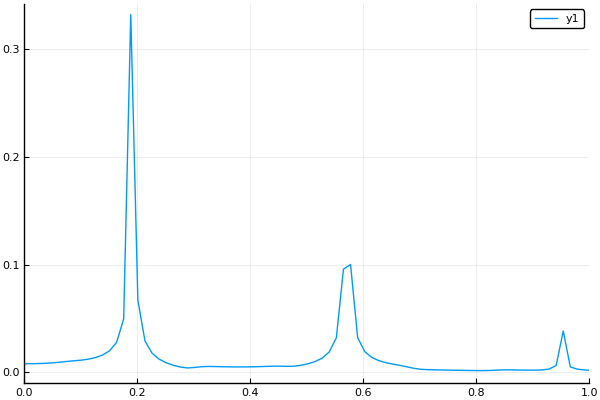

In [127]:
nt = length(thist[2000:end])
nfreq = (nt-1)÷2+1
fsamp = 1/Δt
freq = 0.5*fsamp*range(0,stop=1.0,length=nfreq)
#fhat = fft(fy[2000:nt-1])/(nt-1-2000+1)
fhat = fft(fy[2000:end])/(nt-1)
plot(freq,4*abs.(fhat[1:nfreq]),xlim=(0,1),grid=:true)

In [128]:
freq[findmax(abs.(fhat[1:nfreq]))[2]]

0.18825891876627657